In [32]:
%reload_ext autoreload
%autoreload 2
import os
os.chdir('D:\coam')
os.getcwd()

'D:\\coam'

In [2]:
os.environ['MEGADEPTH'] = 'MEGADEPTH_LOCATION'

In [3]:

import torch
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import glob
import matplotlib.pyplot as plt

from PIL import Image,ImageDraw
import numpy as np
import cv2
from tqdm import tqdm

from options.options import get_dataset, get_model
import models.architectures as architectures

import matplotlib.pyplot as plt
from demo.test import GetMatches, visualise_keypoints, load_coam_model, load_mt_model

In [4]:
# file_name = glob.glob('./pretrainedmodels/effnetB1_ep86.pth')[0]

# old_model = torch.load(file_name)

# # Load the dataset and model
# opts = old_model['opts']
# opts.W = 512

# model = get_model(opts)
# model.load_state_dict(old_model['state_dict'])

# model = model.eval()

# model = model.cuda()



In [5]:
# def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=False):
#     """
#     Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
#     :param nlabels: Number of labels (size of colormap)
#     :param type: 'bright' for strong colors, 'soft' for pastel colors
#     :param first_color_black: Option to use first color as black, True or False
#     :param last_color_black: Option to use last color as black, True or False
#     :param verbose: Prints the number of labels and shows the colormap. True or False
#     :return: colormap for matplotlib
#     """
#     from matplotlib.colors import LinearSegmentedColormap
#     import colorsys
#     import numpy as np


#     if type not in ('bright', 'soft'):
#         print ('Please choose "bright" or "soft" for type')
#         return

#     if verbose:
#         print('Number of labels: ' + str(nlabels))

#     # Generate color map for bright colors, based on hsv
#     if type == 'bright':
#         randHSVcolors = [(np.random.uniform(low=0.0, high=1),
#                           np.random.uniform(low=0.2, high=1),
#                           np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

#         # Convert HSV list to RGB
#         randRGBcolors = []
#         for HSVcolor in randHSVcolors:
#             randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

#         if first_color_black:
#             randRGBcolors[0] = [0, 0, 0]

#         if last_color_black:
#             randRGBcolors[-1] = [0, 0, 0]

#         random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

#     # Generate soft pastel colors, by limiting the RGB spectrum
#     if type == 'soft':
#         low = 0.6
#         high = 0.95
#         randRGBcolors = [(np.random.uniform(low=low, high=high),
#                           np.random.uniform(low=low, high=high),
#                           np.random.uniform(low=low, high=high)) for i in range(nlabels)]

#         if first_color_black:
#             randRGBcolors[0] = [0, 0, 0]

#         if last_color_black:
#             randRGBcolors[-1] = [0, 0, 0]
#         random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

#     # Display colorbar
#     if verbose:
#         from matplotlib import colors, colorbar
#         from matplotlib import pyplot as plt
#         fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

#         bounds = np.linspace(0, nlabels, nlabels + 1)
#         norm = colors.BoundaryNorm(bounds, nlabels)

#         cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
#                                    boundaries=bounds, format='%1i', orientation=u'horizontal')

#     return random_colormap

# def best_matches(sim, cond1=None, cond2=None, topk=8000, T=0.3, nn=1):
#     ''' Find the best matches for a given NxN matrix.
#         Optionally, pass in the actual indices corresponding to this matrix
#         (cond1, cond2) and update the matches according to these indices.
#     '''
#     nn12 = torch.max(sim, dim=1)[1]
#     nn21 = torch.max(sim, dim=0)[1]

#     ids1 = torch.arange(0, sim.shape[0]).to(nn12.device)
#     mask = (ids1 == nn21[nn12])

#     matches = torch.stack([ids1[mask], nn12[mask]])

#     preds = sim[ids1[mask], nn12[mask]]
#     res, ids = preds.sort()
#     ids = ids[res > T]

#     if not(cond1 is None) and not(cond2 is None):
#         cond_ids1 = cond1[ids1[mask]]
#         cond_ids2 = cond2[nn12[mask]]

#         matches = torch.stack([cond_ids1, cond_ids2])

#     matches = matches[:,ids[-topk:]]

#     return matches.t(), None

# def visualise_keypoints(im1, im2, pts, conf1=None, conf2=None, vis_inliners=True, vis_outliers=True):
#     new_cmap = rand_cmap(100, type='bright', first_color_black=True, last_color_black=False, verbose=False)

#     pts = [pts[0], pts[1]]
#     def draw_keypoints(im, pts, imW=im1.size[0]):
#         ptsA, ptsB = pts
#         draw = ImageDraw.Draw(im)
#         r = 4
#         for j in range(0, ptsA.shape[0]):
#             R, G, B, A = new_cmap(j)
#             is_inline = np.linalg.norm(ptsA[j].detach().cpu().numpy() - ptsB[j].detach().cpu().numpy()) < 5
#             if is_inline and vis_inliners:
#                 draw.ellipse([ptsA[j,0] - r, ptsA[j,1] - r, ptsA[j,0] + r, ptsA[j,1] + r], fill=(255,0,0,255))
#                 draw.ellipse([ptsB[j,0] - r + imW, ptsB[j,1] - r, ptsB[j,0] + r + imW, ptsB[j,1] + r], fill=(255,0,0,255))
#                 R, G, B, A = 0, 255, 0, 1
#                 draw.line([ptsA[j,0], ptsA[j,1], ptsB[j,0] + imW, ptsB[j,1]], width=r, fill=(int(R*255), 
#                                                                                              int(G*255), 
#                                                                                              int(B*255), 
#                                                                                              int(A*255)))
#             elif not is_inline and vis_outliers:
#                 draw.ellipse([ptsA[j,0] - r, ptsA[j,1] - r, ptsA[j,0] + r, ptsA[j,1] + r], fill=(255,0,0,255))
#                 draw.ellipse([ptsB[j,0] - r + imW, ptsB[j,1] - r, ptsB[j,0] + r + imW, ptsB[j,1] + r], fill=(255,0,0,255))
#                 R, G, B, A = 255, 0, 0, 1
#                 draw.line([ptsA[j,0], ptsA[j,1], ptsB[j,0] + imW, ptsB[j,1]], width=r, fill=(int(R*255), 
#                                                                                              int(G*255), 
#                                                                                              int(B*255), 
#                                                                                              int(A*255)))
#             elif not vis_inliners and not vis_outliers:                
#                 draw.ellipse([ptsA[j,0] - r, ptsA[j,1] - r, ptsA[j,0] + r, ptsA[j,1] + r], fill=(255,0,0,255))
#                 draw.ellipse([ptsB[j,0] - r + imW, ptsB[j,1] - r, ptsB[j,0] + r + imW, ptsB[j,1] + r], fill=(255,0,0,255))
#                 draw.line([ptsA[j,0], ptsA[j,1], ptsB[j,0] + imW, ptsB[j,1]], width=r, fill=(int(R*255), 
#                                                                                              int(G*255), 
#                                                                                              int(B*255), 
#                                                                                              int(A*255)))
            
            
#     fig = plt.figure(figsize=(30,15))
#     axes = fig.subplots(nrows=1,ncols=1)    
    
#     # Pad to make the heights the same
#     if im1.size[1] < im2.size[1]:
#         W_n, H_n = im1.size
#         W_2, H_2 = im2.size
#         A = H_2 / H_n
        
#         H_n = H_2
#         W_n = int(A * W_n)
        
#         im1 = im1.resize((W_n, H_n))
#         pts[0] = pts[0] * A
#     elif im1.size[1] > im2.size[1]:
#         W_1, H_1 = im1.size
#         W_n, H_n = im2.size
#         A = H_1 / H_n

#         H_n = H_1
#         W_n = int(A * W_n)
#         im2 = im2.resize((W_n, H_n))
#         pts[1] = pts[1] * A
    
        
#     im1 = np.array(im1)
#     im2 = np.array(im2)
    
#     im = Image.fromarray(np.hstack((im1, im2)))
#     draw_keypoints(im, pts, imW=im1.shape[1])
#     axes.imshow(im)
    
#     plt.axis('off')
#     return im
    


In [33]:
# class GetMatches:
#     def __init__(self, model, transform):
#         self.model = model
#         self.transform = transform
        
#     def iterate(self, im1_orig, im2_orig, iters=1):
#         trans_imgs = [np.array(im1_orig.resize(im2_orig.size))]
#         Hs = []
        
#         im1 = self.transform(im1_orig)
#         im2 = self.transform(im2_orig)
            
#         W1, H1 = im1_orig.size
#         W2, H2 = im2_orig.size

#         # Now visualise heat map for a given point
#         with torch.no_grad():
#             results = model.run_feature((im1.unsqueeze(0).cuda(), None), (im2.unsqueeze(0).cuda(), None), 
#                 MAX=16384, keypoints=None, sz1=(128,128), sz2=(128,128), 
#                 factor=1, r_im1=(1,1), r_im2=(1,1), 
#                 use_conf=1, T=0.1, 
#                 return_4dtensor=True, RETURN_ALLKEYPOINTS=True)

#         matches, ratio = best_matches(results['match'].view(128*128,128*128), topk=200, T=0)
#         _, idxs = matches[:,0].sort(dim=0)
#         matches = matches[idxs,:]
#         # matches = matches[1::(100//20),:][:,:]
        
#         WG=128; RG = 1

#         kps1 = results['kp1'].clone()
#         kps1[:,0] = (results['kp1'][:,0] / (1 * 2.) + 0.5) * W1
#         kps1[:,1] = (results['kp1'][:,1] / (1 * 2.) + 0.5) * H1

#         kps2 = results['kp2'].clone()
#         kps2[:,0] = (results['kp2'][:,0] / (1 * 2.)  + 0.5) * W2
#         kps2[:,1] = (results['kp2'][:,1] / (1 * 2.)  + 0.5) * H2
        
#         return kps1[matches[:,0],:], kps2[matches[:,1],:]

def match_and_vis(coam_model, mt_model, im1, im2, vis_inliners=False, vis_outliers=False, use_mt_model=False, use_original_keypoints=True):
    # Load in two images
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    im1_orig = Image.open(im1).convert("RGB")
    im2_orig = Image.open(im2).convert("RGB")


#     fig, axes = plt.subplots(1,2, figsize=(10,20))
#     axes[0].imshow(im1_orig)
#     axes[0].axis('off')

#     axes[1].imshow(im2_orig)
#     axes[1].axis('off')

    get_matches = GetMatches(coam_model, mt_model, transform, use_external_desc=use_mt_model, use_original_keypoints=use_original_keypoints)
    kps1, kps2 = get_matches.iterate(im1_orig, im2_orig, iters=2)

    im = visualise_keypoints(im1_orig, im2_orig, (kps1, kps2), vis_inliners=vis_inliners, vis_outliers=vis_outliers)
    dist = np.linalg.norm(kps1.detach().cpu().numpy() - kps2.detach().cpu().numpy(), axis=1)
    inliners = dist[dist < 5]
    outliers = dist[dist >= 5]
    mean_error = 0.0
    if outliers.any():
        mean_error = np.mean([d for d in outliers])
    print(f'Inliners/Outliers: {len(inliners)}/{len(outliers)}, Mean error: {mean_error}')
    plt.show()

Namespace(V=32, W=512, WCoarse=128, WHier=[64, 128], affine_model='', batch_size=16, best_epoch=-1, beta1=0, beta2=0.9, continue_epoch=0, dataset='megadepth', dataset_base_path='', depth=2, epoch=-1, exp_idx=4, factor=0.01, feature_model='', gpu_idx=0, hard_samples=512, hidden_size=128, hinge_samples=3, in_vec=256, jitter=0, keep_aspect=0, lambda1=1, lambda2=1, lambda3=1, lambda_feat=1, load_old_model=False, log_dir='', losses='hinge', lr=0.0001, lr_d=0.002, max_epochs=50, max_warps=1, model_epoch_path='', model_type='fpn_conf_broad', model_zoo='~/.model_zoo', momentum=0.9, n_warps=1, network='efficientnet-b1', ngf=32, norm_D='spectralinstance', norm_class='batch_norm', num_workers=5, old_model='', resume=1, run_dir='runs/%s_lr%0.5f_bs%d_model%s_adam_dp%d_loss%s_lambs%0.4f|%0.4f|%0.4f/', sample=False, second_curriculum=False, start_epoch=0, suffix='resnet50_megasplit_regandclass_upsbilinear_attention_noscse_00004_network=efficientnet-b1_train_end2end=0', topk=1, track_best_loss=1000, t

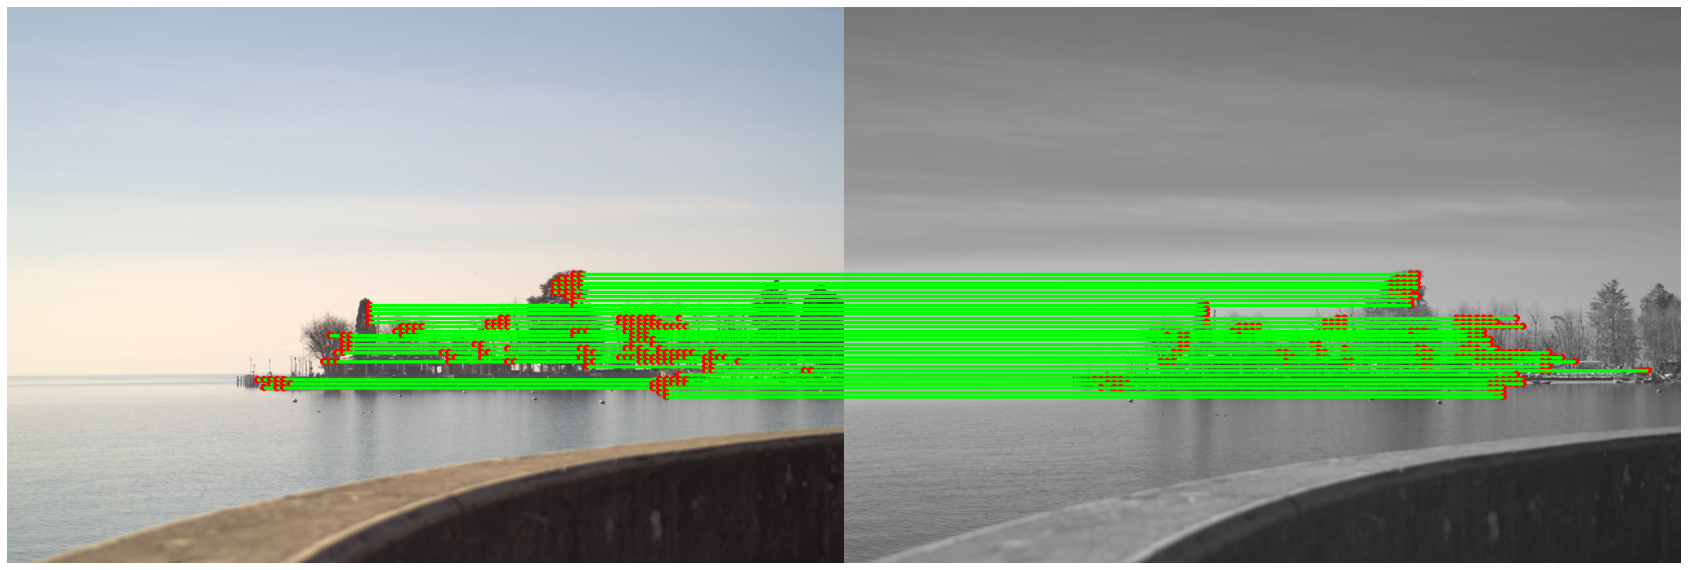

In [34]:
# Consider two specific images
# im1 = './demo/imgs/col1.jpeg'
# im2 = './demo/imgs/col2.jpeg'
coam_model = load_coam_model()
mt_model = load_mt_model()
im1 = 'D:/multisensor/datasets/Vis-Nir/data/water/0003_rgb.tiff'
im2 = 'D:/multisensor/datasets/Vis-Nir/data/water/0003_nir.tiff'
match_and_vis(coam_model, mt_model, im1, im2, vis_inliners=True, vis_outliers=True, use_mt_model=False)

Inliners/Outliers: 200/0, Mean error: 0.0


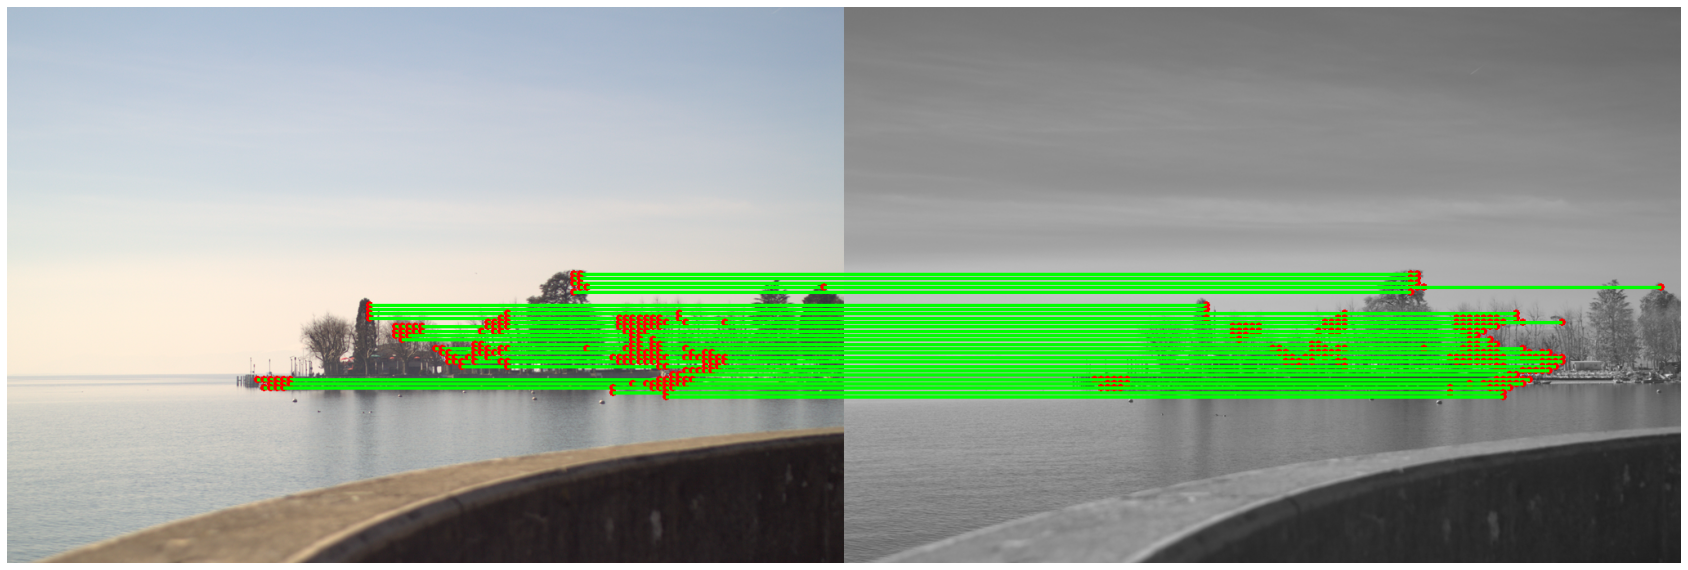

In [36]:
match_and_vis(coam_model, mt_model, im1, im2, vis_inliners=True, vis_outliers=True, use_mt_model=True, use_original_keypoints=False)

In [15]:
from pathlib import Path
def load_test_files(dir):
    rgb = []
    nir = []
    for path in Path(dir).rglob('*_rgb.tiff'):
        full_path = str(path.resolve())
        if '\\country\\' not in full_path:
            rgb.append(full_path)
            nir.append(full_path.replace('_rgb', '_nir'))
    return rgb, nir
rgb, nir = load_test_files('D:/multisensor/datasets/Vis-Nir/data')
print('Loaded', len(rgb) + len(nir), 'files')

Loaded 850 files


In [24]:
results = {}
for im1, im2 in zip(rgb, nir):
    # Load in two images
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    im1_orig = Image.open(im1).convert("RGB")
    im2_orig = Image.open(im2).convert("RGB")

    get_matches = GetMatches(coam_model, mt_model, transform)
    kps1, kps2 = get_matches.iterate(im1_orig, im2_orig, iters=2)
    dist = np.linalg.norm(kps1.detach().cpu().numpy() - kps2.detach().cpu().numpy(), axis=1)
    inliners = dist[dist < 5]
    outliers = dist[dist >= 5]
    results[(im1, im2)] = {
        'inliners': inliners,
        'outliers': outliers
    }

In [25]:
inliners_mean = np.mean([len(res['inliners']) for _, res in results.items()])
outliers_mean = np.mean([len(res['outliers']) for _, res in results.items()])
mean_error = np.mean([d for _, res in results.items() for d in res['outliers']])
print(f'Inliners/Outliers: {inliners_mean}/{outliers_mean}')
print(f'Mean error: {mean_error}')

Inliners/Outliers: 189.16470588235293/10.83529411764706
Mean error: 56.39189910888672


In [37]:
results_with_mt_model = {}
for im1, im2 in zip(rgb, nir):
    # Load in two images
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    im1_orig = Image.open(im1).convert("RGB")
    im2_orig = Image.open(im2).convert("RGB")

    get_matches = GetMatches(coam_model, mt_model, transform, use_external_desc=True, use_original_keypoints=False)
    kps1, kps2 = get_matches.iterate(im1_orig, im2_orig, iters=2)
    dist = np.linalg.norm(kps1.detach().cpu().numpy() - kps2.detach().cpu().numpy(), axis=1)
    inliners = dist[dist < 5]
    outliers = dist[dist >= 5]
    results_with_mt_model[(im1, im2)] = {
        'inliners': inliners,
        'outliers': outliers
    }

In [38]:
inliners_mean = np.mean([len(res['inliners']) for _, res in results_with_mt_model.items()])
outliers_mean = np.mean([len(res['outliers']) for _, res in results_with_mt_model.items()])
mean_error = np.mean([d for _, res in results_with_mt_model.items() for d in res['outliers']])
print(f'Inliners/Outliers with multiscale model: {inliners_mean}/{outliers_mean}')
print(f'Mean error with multiescale model: {mean_error}')

Inliners/Outliers with multiscale model: 189.64/8.901176470588235
Mean error with multiescale model: 20.559829711914062


In [26]:
nonzero_outliers = {k: res for k, res in results.items() if len(res['outliers']) > 0}
len(nonzero_outliers)

86

In [ ]:
for im1, im2 in nonzero_outliers:
    match_and_vis(coam_model, mt_model, im1, im2, vis_outliers=True)
    match_and_vis(coam_model, mt_model, im1, im2, vis_outliers=True, use_mt_model=True, use_original_keypoints=False)